# Daily Total Female Births

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from prophet import Prophet
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm


print("\nCARGA Y PREPARACIÓN DE DATOS")
print("-" * 30)

df = pd.read_csv('daily-total-female-births.csv')
print(f"Dimensiones del dataset: {df.shape}")
print(f"Rango de fechas: {df['Date'].iloc[0]} a {df['Date'].iloc[-1]}")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print(f"Estadísticas descriptivas:")
print(df.describe())

Importing plotly failed. Interactive plots will not work.



1️CARGA Y PREPARACIÓN DE DATOS
------------------------------
Dimensiones del dataset: (365, 2)
Rango de fechas: 1959-01-01 a 1959-12-31
Estadísticas descriptivas:
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000



ANÁLISIS EXPLORATORIO
------------------------------


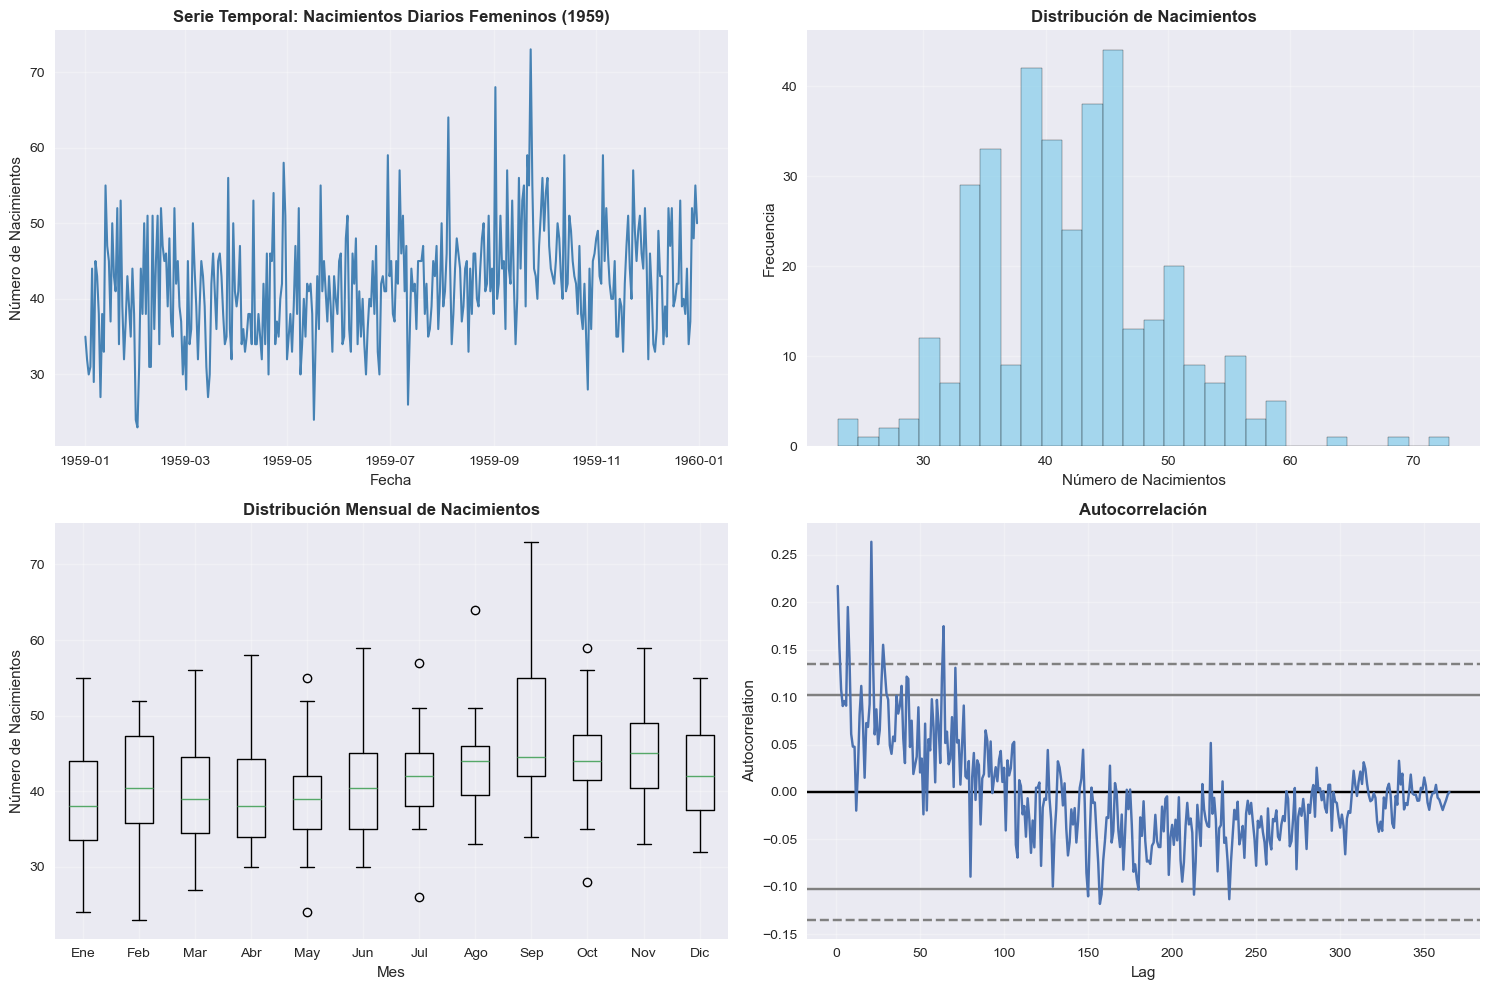

Análisis de Componentes:


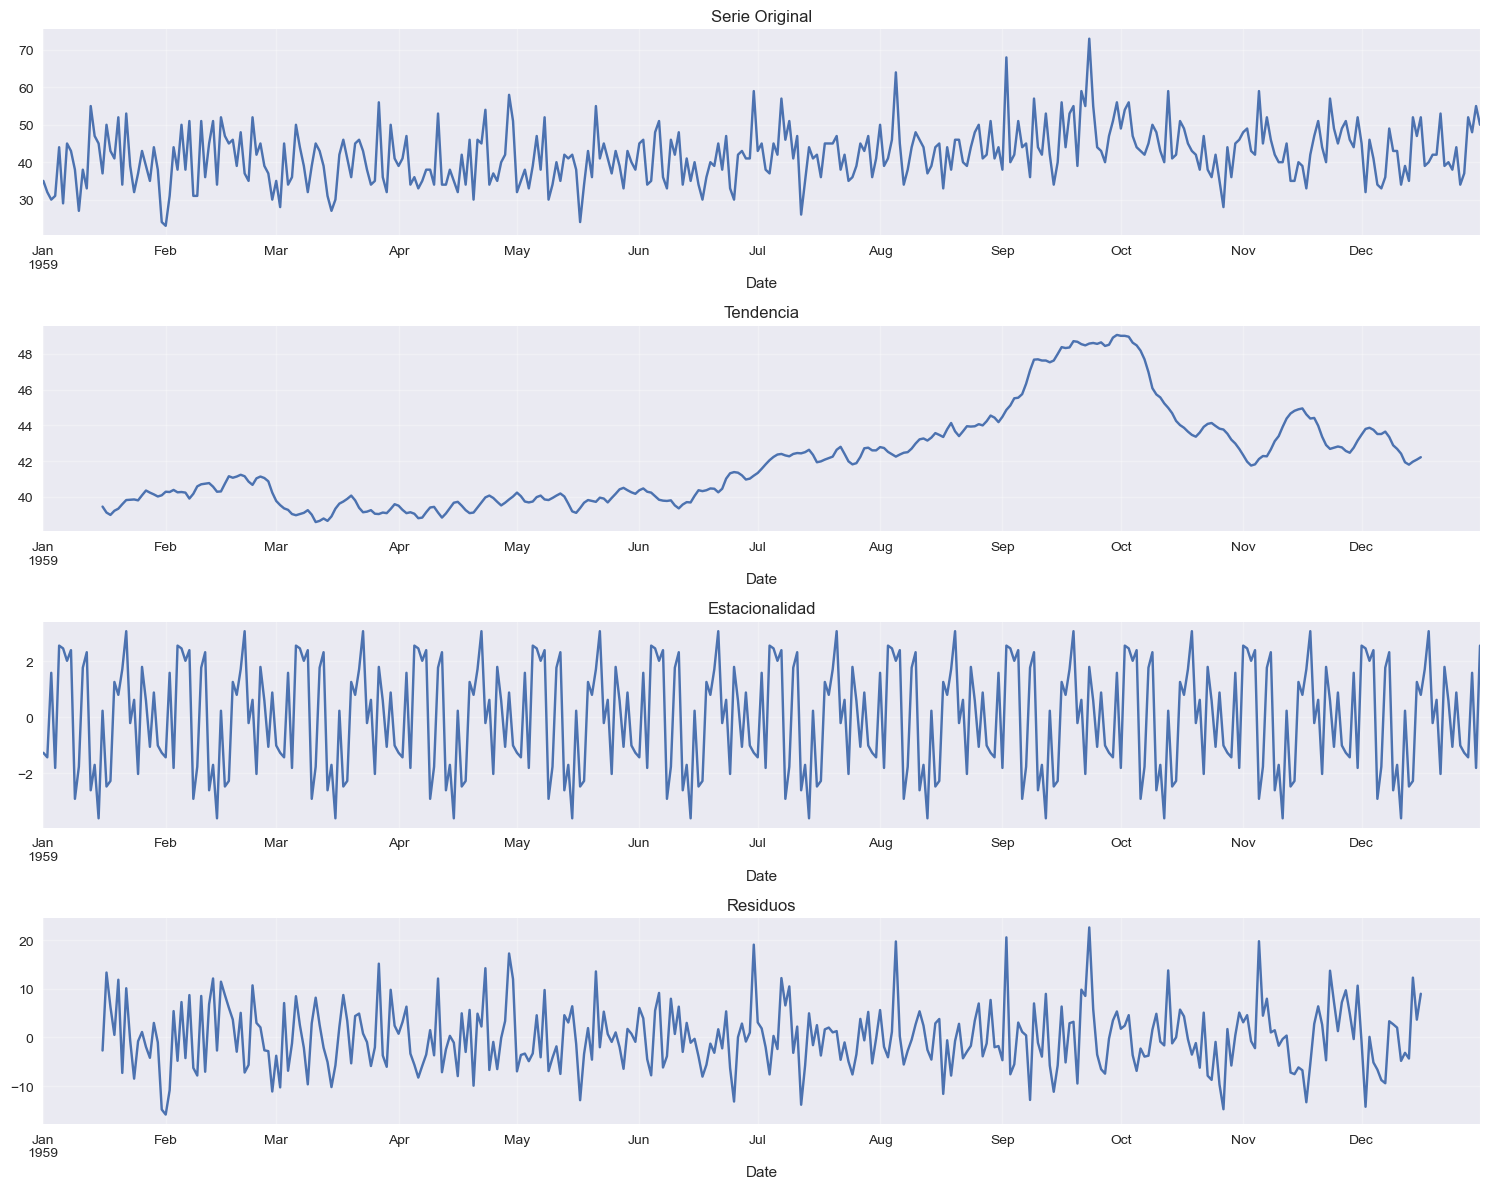

Test ADF - Serie Original:
   ADF Statistic: -4.808291
   p-value: 0.000052
   Es estacionaria: Sí


In [2]:
print("\nANÁLISIS EXPLORATORIO")
print("-" * 30)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(df.index, df['Births'], linewidth=1.5, color='steelblue')
axes[0,0].set_title('Serie Temporal: Nacimientos Diarios Femeninos (1959)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Número de Nacimientos')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(df['Births'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Distribución de Nacimientos', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Número de Nacimientos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

df['Month'] = df.index.month
monthly_data = [df[df['Month'] == month]['Births'].values for month in range(1, 13)]
axes[1,0].boxplot(monthly_data, labels=['Ene','Feb','Mar','Abr','May','Jun',
                                       'Jul','Ago','Sep','Oct','Nov','Dic'])
axes[1,0].set_title('Distribución Mensual de Nacimientos', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Mes')
axes[1,0].set_ylabel('Número de Nacimientos')
axes[1,0].grid(True, alpha=0.3)

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Births'], ax=axes[1,1])
axes[1,1].set_title('Autocorrelación', fontsize=12, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Análisis de Componentes:")
decomposition = seasonal_decompose(df['Births'], model='additive', period=365//12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Serie Original')
decomposition.trend.plot(ax=axes[1], title='Tendencia')
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
decomposition.resid.plot(ax=axes[3], title='Residuos')

for ax in axes:
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"Test ADF {title}:")
    print(f"   ADF Statistic: {result[0]:.6f}")
    print(f"   p-value: {result[1]:.6f}")
    print(f"   Es estacionaria: {'Sí' if result[1] <= 0.05 else 'No'}")
    return result[1] <= 0.05

is_stationary = adf_test(df['Births'], "- Serie Original")

In [3]:
print("\nDIVISIÓN DE DATOS")
print("-" * 30)

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Datos de entrenamiento: {len(train_data)} observaciones")
print(f"Datos de prueba: {len(test_data)} observaciones")


DIVISIÓN DE DATOS
------------------------------
Datos de entrenamiento: 292 observaciones
Datos de prueba: 73 observaciones



PROMEDIOS MÓVILES
------------------------------


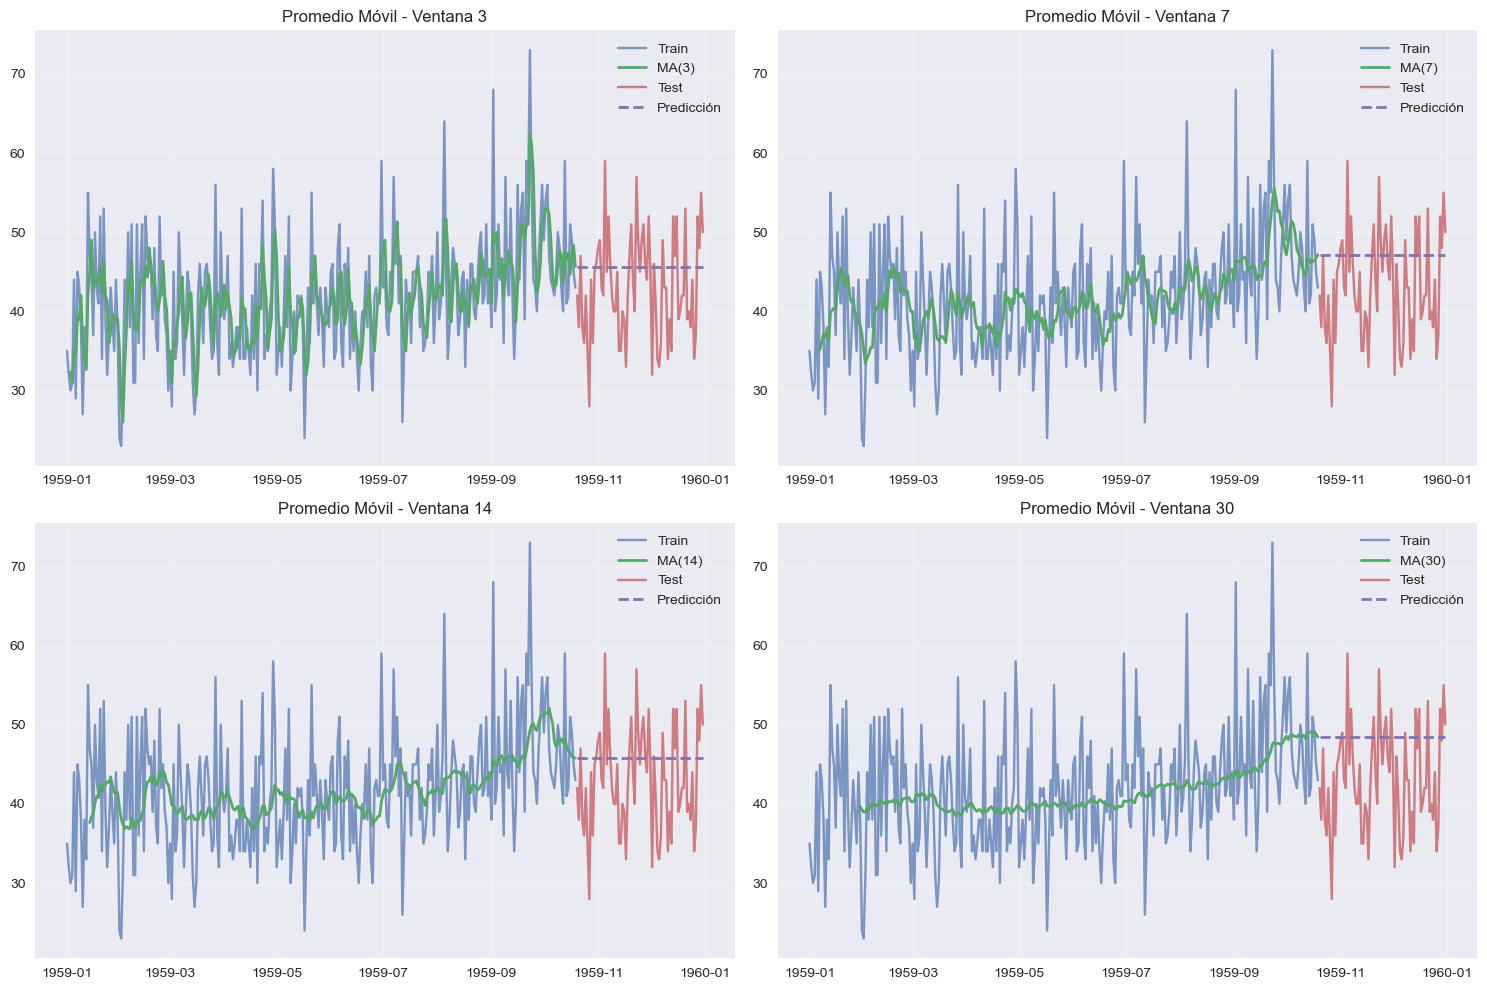

In [4]:
print("\nPROMEDIOS MÓVILES")
print("-" * 30)

windows = [3, 7, 14, 30]
ma_predictions = {}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, window in enumerate(windows):
    ma = train_data['Births'].rolling(window=window).mean()
    
    last_ma = ma.iloc[-1]
    prediction = [last_ma] * len(test_data)
    ma_predictions[f'MA_{window}'] = prediction
    
    axes[i].plot(train_data.index, train_data['Births'], label='Train', alpha=0.7)
    axes[i].plot(train_data.index, ma, label=f'MA({window})', linewidth=2)
    axes[i].plot(test_data.index, test_data['Births'], label='Test', alpha=0.7)
    axes[i].plot(test_data.index, prediction, label='Predicción', linewidth=2, linestyle='--')
    axes[i].set_title(f'Promedio Móvil - Ventana {window}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



ALISAMIENTO EXPONENCIAL
------------------------------


/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


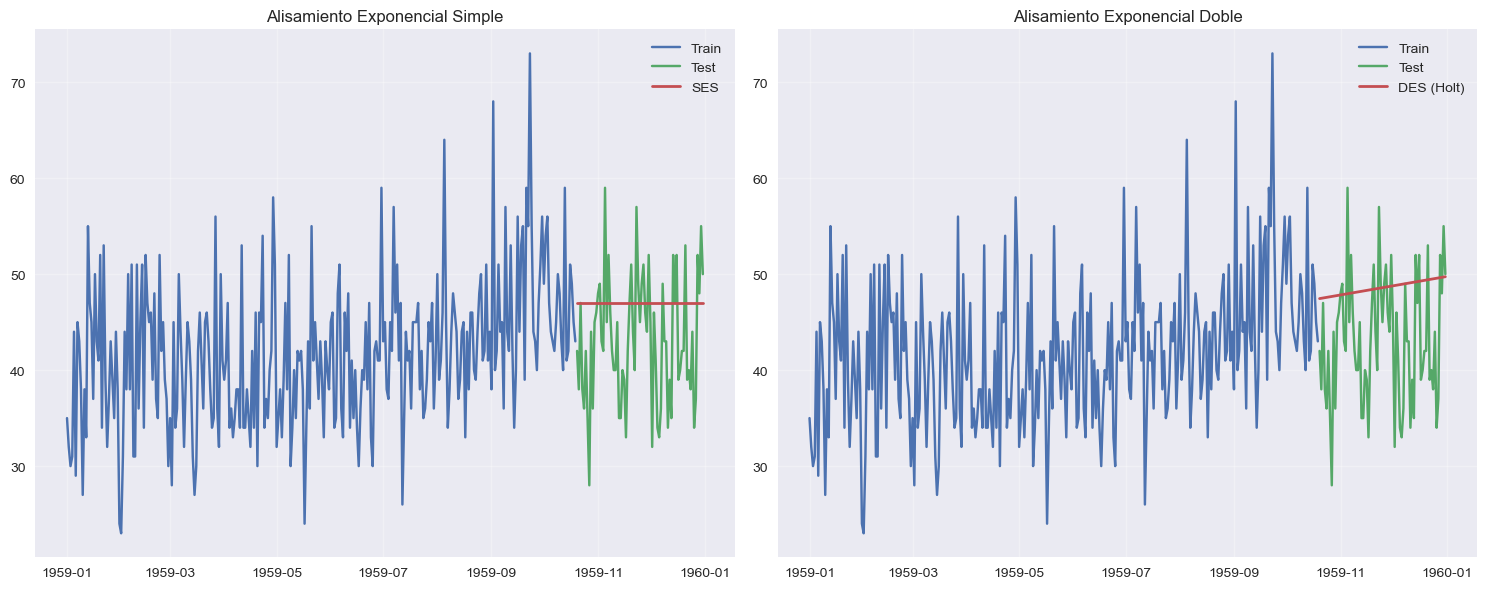

In [5]:
print("\nALISAMIENTO EXPONENCIAL")
print("-" * 30)

ses = ExponentialSmoothing(train_data['Births'], trend=None, seasonal=None)
ses_fit = ses.fit()
ses_pred = ses_fit.forecast(len(test_data))

des = ExponentialSmoothing(train_data['Births'], trend='add', seasonal=None)
des_fit = des.fit()
des_pred = des_fit.forecast(len(test_data))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(train_data.index, train_data['Births'], label='Train')
axes[0].plot(test_data.index, test_data['Births'], label='Test')
axes[0].plot(test_data.index, ses_pred, label='SES', linewidth=2)
axes[0].set_title('Alisamiento Exponencial Simple')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_data.index, train_data['Births'], label='Train')
axes[1].plot(test_data.index, test_data['Births'], label='Test')
axes[1].plot(test_data.index, des_pred, label='DES (Holt)', linewidth=2)
axes[1].set_title('Alisamiento Exponencial Doble')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


HOLT-WINTERS
------------------------------


/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


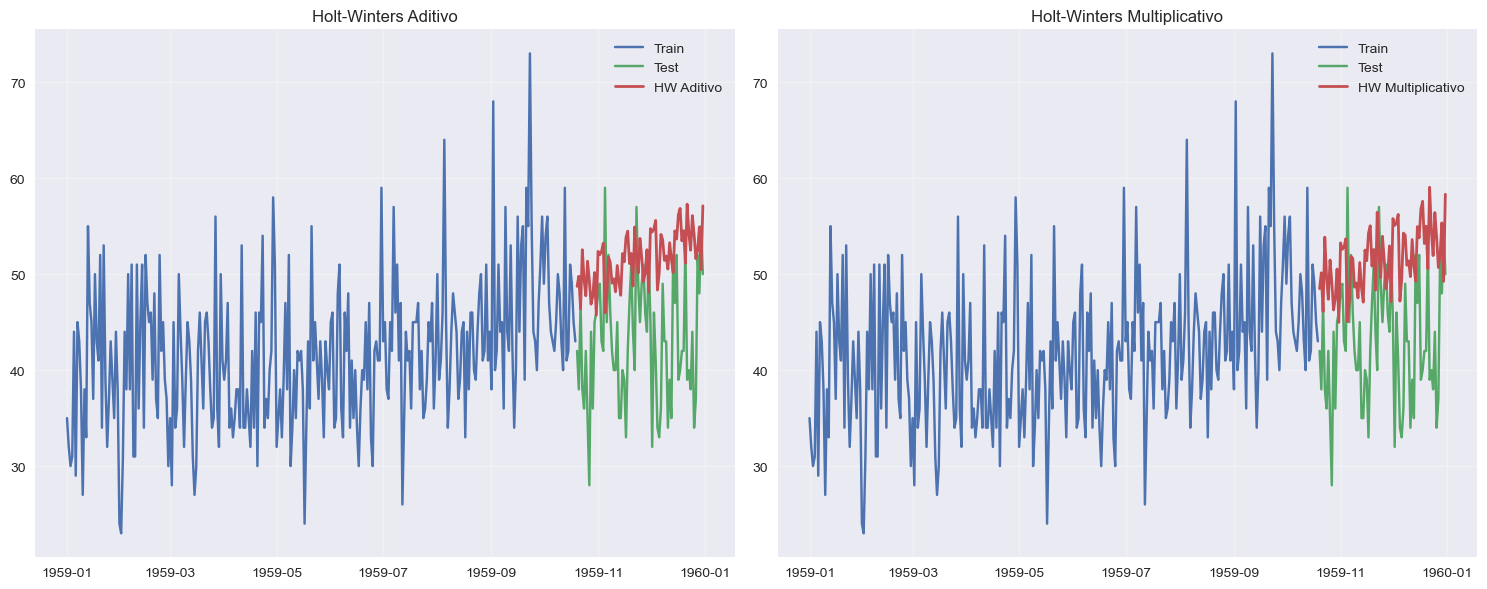

In [6]:
print("\nHOLT-WINTERS")
print("-" * 30)

try:
    hw_add = ExponentialSmoothing(train_data['Births'], 
                                  trend='add', 
                                  seasonal='add', 
                                  seasonal_periods=30)  
    hw_add_fit = hw_add.fit()
    hw_add_pred = hw_add_fit.forecast(len(test_data))
    
    hw_mul = ExponentialSmoothing(train_data['Births'], 
                                  trend='add', 
                                  seasonal='mul', 
                                  seasonal_periods=30)
    hw_mul_fit = hw_mul.fit()
    hw_mul_pred = hw_mul_fit.forecast(len(test_data))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].plot(train_data.index, train_data['Births'], label='Train')
    axes[0].plot(test_data.index, test_data['Births'], label='Test')
    axes[0].plot(test_data.index, hw_add_pred, label='HW Aditivo', linewidth=2)
    axes[0].set_title('Holt-Winters Aditivo')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(train_data.index, train_data['Births'], label='Train')
    axes[1].plot(test_data.index, test_data['Births'], label='Test')
    axes[1].plot(test_data.index, hw_mul_pred, label='HW Multiplicativo', linewidth=2)
    axes[1].set_title('Holt-Winters Multiplicativo')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error en Holt-Winters: {e}")
    hw_add_pred = ses_pred  
    hw_mul_pred = ses_pred


MODELO SARIMA
------------------------------
Buscando mejores parámetros SARIMA
Mejor modelo: (0, 1, 1) x (0, 0, 0, 30)


/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


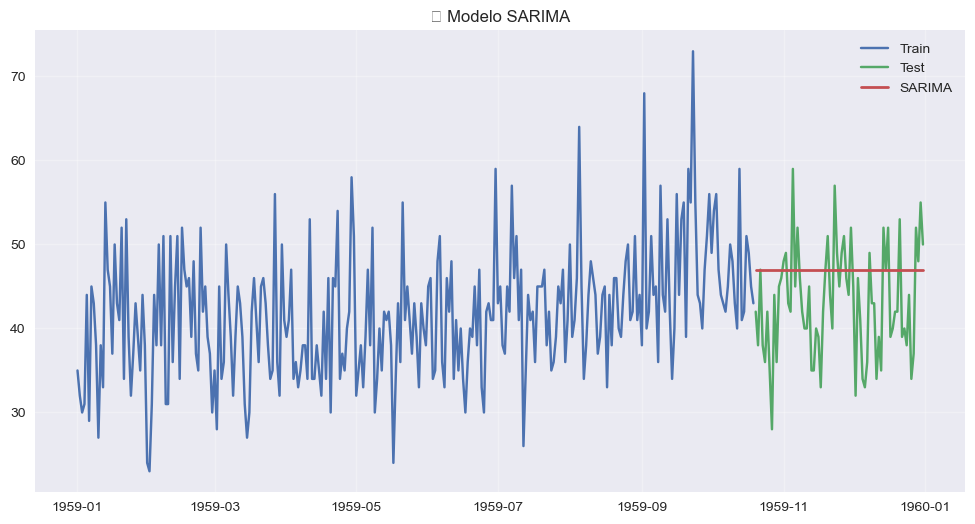

In [7]:
print("\nMODELO SARIMA")
print("-" * 30)

try:
    print("Buscando mejores parámetros SARIMA")
    auto_arima = pm.auto_arima(train_data['Births'],
                               start_p=0, start_q=0,
                               max_p=3, max_q=3,
                               seasonal=True,
                               start_P=0, start_Q=0,
                               max_P=2, max_Q=2, m=30,
                               stepwise=True,
                               suppress_warnings=True,
                               error_action='ignore')
    
    print(f"Mejor modelo: {auto_arima.order} x {auto_arima.seasonal_order}")
    
    sarima_model = SARIMAX(train_data['Births'],
                           order=auto_arima.order,
                           seasonal_order=auto_arima.seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.forecast(len(test_data))
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Births'], label='Train')
    plt.plot(test_data.index, test_data['Births'], label='Test')
    plt.plot(test_data.index, sarima_pred, label='SARIMA', linewidth=2)
    plt.title('📈 Modelo SARIMA')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"⚠️ Error en SARIMA: {e}")
    sarima_pred = ses_pred  


MODELO PROPHET
------------------------------


19:20:32 - cmdstanpy - INFO - Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing


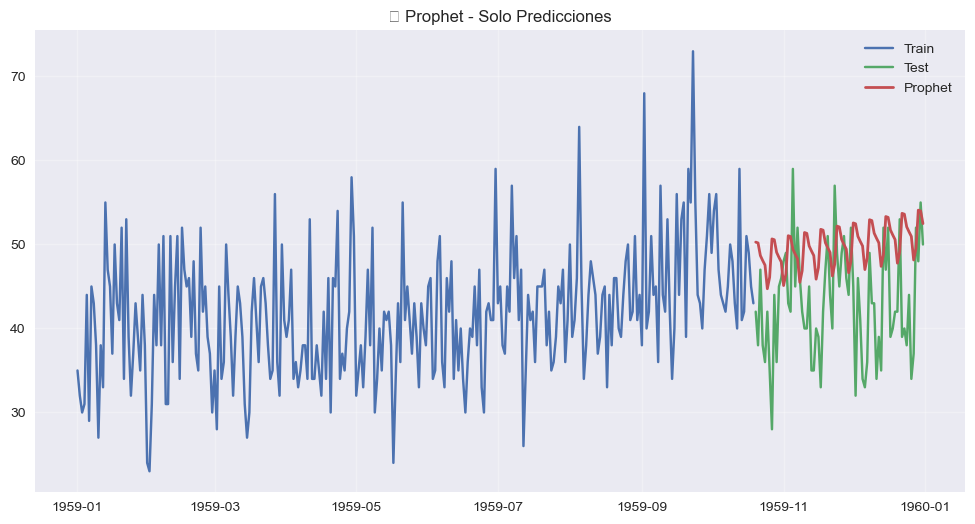

✅ Prophet funcionó correctamente


In [ ]:
print("\nMODELO PROPHET")
print("-" * 30)

PROPHET_AVAILABLE = True

if PROPHET_AVAILABLE:
    try:
        prophet_train = pd.DataFrame({
            'ds': train_data.index,
            'y': train_data['Births'].values
        })
        
        prophet_train = prophet_train.dropna()
        
        prophet_model = Prophet(
            yearly_seasonality=False,  
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'  
        )
        
        prophet_model.fit(prophet_train)
        
        future_dates = pd.date_range(
            start=test_data.index[0], 
            periods=len(test_data), 
            freq='D'
        )
        future_df = pd.DataFrame({'ds': future_dates})
        prophet_forecast = prophet_model.predict(future_df)
        prophet_pred = prophet_forecast['yhat'].values
        
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data['Births'], label='Train')
        plt.plot(test_data.index, test_data['Births'], label='Test')
        plt.plot(test_data.index, prophet_pred, label='Prophet', linewidth=2)
        plt.title('🔮 Prophet - Solo Predicciones')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        
    except Exception as e:
        print(f"Error en Prophet: {e}")
        prophet_pred = ses_pred
else:
    prophet_pred = ses_pred



EVALUACIÓN Y COMPARACIÓN
------------------------------
RESULTADOS DE EVALUACIÓN:
  Model   MAE   RMSE   MAPE
    SES 6.208  7.539 15.944
 SARIMA 6.224  7.557 15.990
   MA_7 6.292  7.629 16.179
    DES 6.957  8.472 18.083
Prophet 8.034  9.527 20.720
 HW_Add 9.511 11.185 24.427


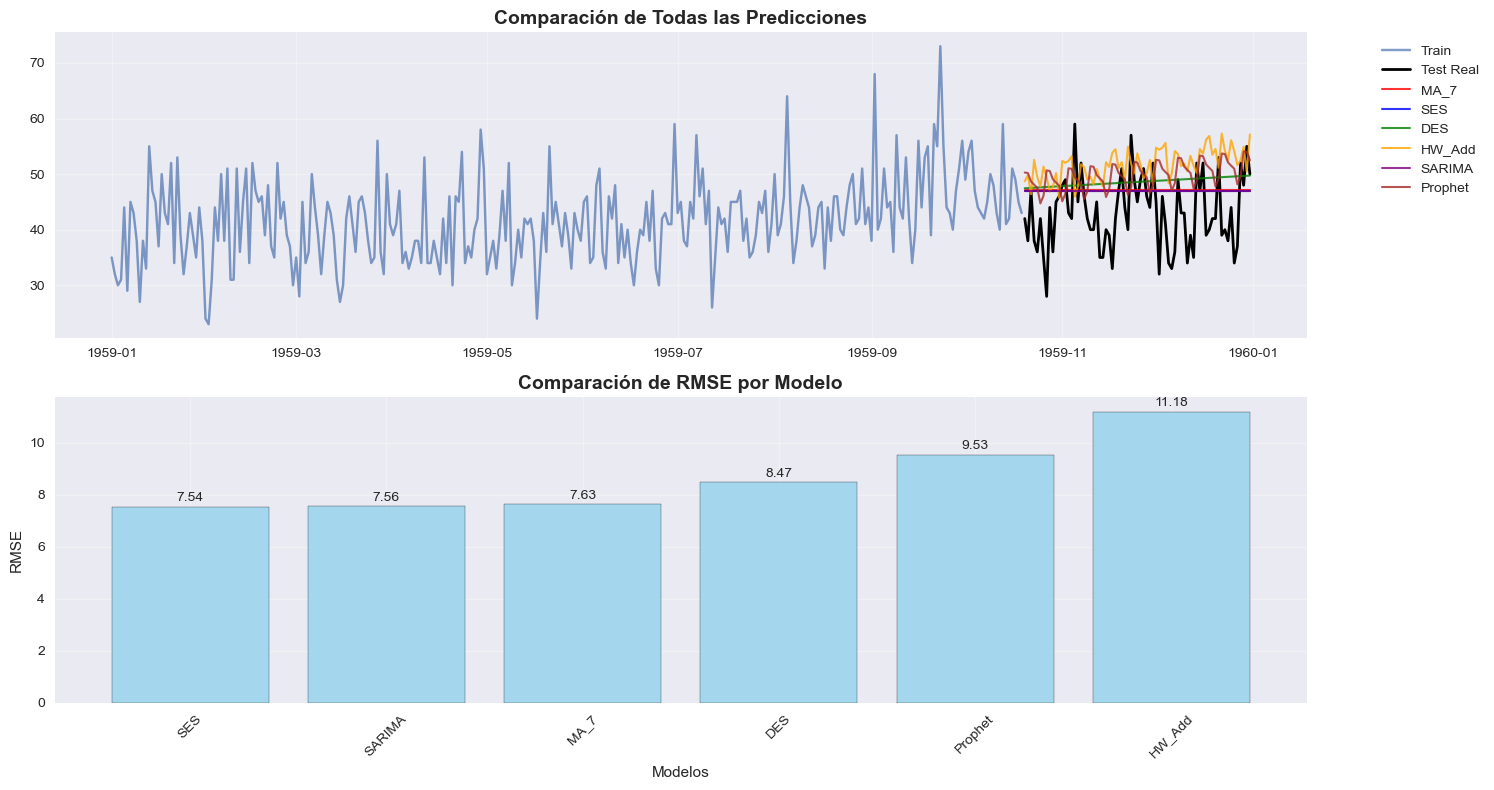

In [13]:
print("\nEVALUACIÓN Y COMPARACIÓN")
print("-" * 30)

def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

predictions = {
    'MA_7': ma_predictions.get('MA_7', [np.mean(train_data['Births'])] * len(test_data)),
    'SES': ses_pred,
    'DES': des_pred,
    'HW_Add': hw_add_pred,
    'SARIMA': sarima_pred,
    'Prophet': prophet_pred
}

results = []
for name, pred in predictions.items():
    try:
        metrics = calculate_metrics(test_data['Births'].values, pred, name)
        results.append(metrics)
    except Exception as e:
        print(f"Error calculando métricas para {name}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("RESULTADOS DE EVALUACIÓN:")
print("=" * 50)
print(results_df.to_string(index=False, float_format='%.3f'))

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Births'], label='Train', alpha=0.7)
plt.plot(test_data.index, test_data['Births'], label='Test Real', linewidth=2, color='black')

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, (name, pred) in enumerate(predictions.items()):
    plt.plot(test_data.index, pred, label=name, linewidth=1.5, 
             color=colors[i % len(colors)], alpha=0.8)

plt.title('Comparación de Todas las Predicciones', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
x_pos = np.arange(len(results_df))
bars = plt.bar(x_pos, results_df['RMSE'], alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE por Modelo', fontsize=14, fontweight='bold')
plt.xticks(x_pos, results_df['Model'], rotation=45)
plt.grid(True, alpha=0.3)

for bar, rmse in zip(bars, results_df['RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{rmse:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
print("\nCONCLUSIONES Y ANÁLISIS")
print("=" * 50)

best_model = results_df.iloc[0]
print(f"Mejor modelo: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.3f}")
print(f"   MAE: {best_model['MAE']:.3f}")
print(f"   MAPE: {best_model['MAPE']:.2f}%")

print("\nCaracterísticas de la serie:")
print(f"   Tendencia: {'Presente' if decomposition.trend.dropna().std() > 1 else 'Ausente'}")
print(f"   Estacionalidad: {'Presente' if decomposition.seasonal.dropna().std() > 1 else 'Débil'}")
print(f"   Estacionariedad: {'Sí' if is_stationary else 'No'}")

print("\nRecomendaciones:")
if best_model['Model'] in ['SARIMA', 'Prophet']:
    print("   Los modelos avanzados (SARIMA/Prophet) son más efectivos")
    print("   La serie tiene patrones complejos que requieren modelos sofisticados")
elif best_model['Model'] in ['SES', 'DES', 'HW_Add']:
    print("   Los métodos de alisamiento exponencial son efectivos")
    print("   La serie tiene patrones de tendencia/estacionalidad manejables")
else:
    print("   Los métodos simples son suficientes para esta serie")
    print("   La serie es relativamente estable sin patrones complejos")


CONCLUSIONES Y ANÁLISIS
Mejor modelo: SES
   RMSE: 7.539
   MAE: 6.208
   MAPE: 15.94%

Características de la serie:
   Tendencia: Presente
   Estacionalidad: Presente
   Estacionariedad: Sí

Recomendaciones:
   Los métodos de alisamiento exponencial son efectivos
   La serie tiene patrones de tendencia/estacionalidad manejables
